# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Hyperparameters](#Hyperparameters)
* [Discussion](#Discussion)

# Introduction

This is a post hoc tuning after seeing disappointing holdout results. We dropped ridge earlier for simplicity and speed, but now it's back in.

Since I'm close to wrapping up at this point, we'll do a quick tune and won't stop to evaluate too much.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

import swifter

# typing
from typing import Dict, List

# other sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold

from scipy.stats import loguniform

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.73 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final features
FEATURES_FOLDER = "../19.0-mic-extract_FRILL-based_features_from_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 115 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "lang1",
        "length",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(unscaled=False) -> pd.DataFrame:
    """Loads the FRILL-based features"""
    if unscaled:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/unscaled_features_ready_for_selection.feather"
        ).set_index("id")
    else:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/features_ready_for_selection.feather"
        ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data(unscaled=True)
labels = load_labels()
y_true = labels.valence
gnb_features = ["spherical-LDA1", "spherical-LDA2"]
assert all(data.index == labels.index)
_ = gc_collect()

time: 338 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 118 entries, theta_LDA1+LDA2 to LDA-ocSVM_poly6_pos
dtypes: float64(118)
memory usage: 78.8 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          86752 non-null  category
 1   speaker_id      86752 non-null  category
 2   speaker_gender  86752 non-null  category
 3   emo             86752 non-null  category
 4   valence         86752 non-null  int8    
 5   lang1           86752 non-null  category
 6   length          86752 non-null  category
dtypes: category(6), int8(1)
memory usage: 1.4 MB
time: 28 ms


# Strata

In [7]:
N_SPLITS = 7

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Dask Apply: 100%|██████████| 16/16 [00:02<00:00,  5.95it/s]


time: 5.58 s


In [8]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 128 ms


In [9]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
STRATA.value_counts()
cross_validator = lambda: StratifiedGroupKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=SEED
).split(X=data, y=STRATA, groups=labels.speaker_id)

merge passes performed: 0
only 1: 53
only 2: 39
only 3: 31
only 4: 17
only 5: 27
only 6: 13
merge passes performed: 1
only 1: 40
only 2: 12
only 3: 14
only 4: 0
only 5: 0
only 6: 0
merge passes performed: 2
only 1: 26
only 2: 0
only 3: 0
only 4: 20
only 5: 0
only 6: 0
merge passes performed: 3
only 1: 6
only 2: 0
only 3: 0
only 4: 0
only 5: 20
only 6: 0
merge passes performed: 4
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 14
only 6: 6
merge passes performed: 5
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 8
only 6: 0
merge passes performed: 6
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0


MELDmneu1engmedium               2905
MELDfneu1engmedium               2452
esdfsur0engmedium                1750
esdfhap2engmedium                1750
esdfneu1engmedium                1750
esdmneu1cmnmedium                1750
esdmhap2cmnmedium                1750
esdmang0cmnmedium                1750
esdfhap2cmnmedium                1749
esdfneu1cmnmedium                1749
esdmsur0cmnmedium                1749
esdmsur0engmedium                1749
esdfang0engmedium                1748
esdfang0cmnmedium                1747
esdmneu1engmedium                1747
esdmang0engmedium                1746
esdmhap2engmedium                1744
esdfsad0engmedium                1744
esdfsur0cmnmedium                1737
esdmsad0engmedium                1735
esdmsad0cmnmedium                1713
LEGOv2fneu1engmedium             1673
esdfsad0cmnmedium                1474
LEGOv2mneu1engmedium             1309
MELDfhap2engmedium                931
MELDmhap2engmedium                908
EmoV-DB_sort

time: 1.83 s


# Hyperparameters

In [10]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={
        "base_estimator__alpha": loguniform(1e-3, 1e3),
        "base_estimator__class_weight": ["balanced", None],
    },
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 1,
    error_score="raise",
).fit(data, labels.valence)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
time: 36.4 s


-0.28368492329744643
{'base_estimator__alpha': 1.2001774651607644, 'base_estimator__class_weight': None}


<AxesSubplot:xlabel='param_base_estimator__alpha'>

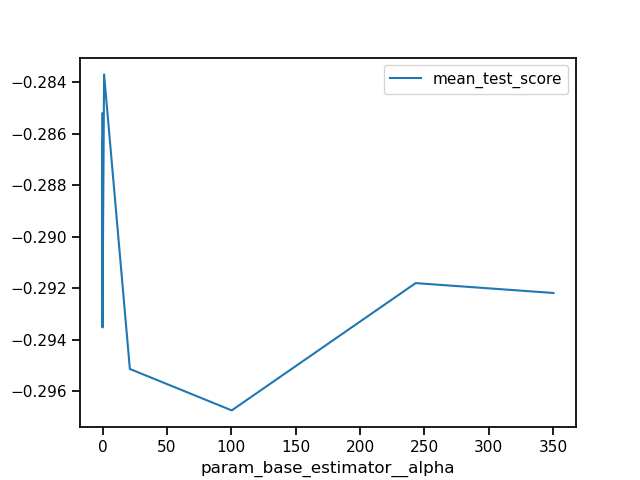

time: 260 ms


In [11]:
print(model.best_score_)
print(model.best_params_)
results_df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")

In [12]:
df = pd.DataFrame(model.cv_results_)
df.param_base_estimator__class_weight = df.param_base_estimator__class_weight.astype(
    str
)
df.groupby("param_base_estimator__class_weight").mean()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
param_base_estimator__class_weight,,,,,,,,,,,,,,
None,3.163473,0.194541,0.137511,0.048408,-0.310404,-0.249706,-0.256274,-0.293048,-0.320004,-0.238289,-0.347055,-0.287826,0.037803,3.0
balanced,3.275799,0.246485,0.143380,0.048296,-0.316002,-0.255380,-0.259712,-0.297279,-0.329306,-0.241015,-0.360918,-0.294230,0.040920,8.0


time: 31 ms


In [13]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={"base_estimator__alpha": loguniform(1e-3, 1e3)},
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 2,
    error_score="raise",
).fit(data, labels.valence)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
time: 34.2 s


-0.2836503909107266
{'base_estimator__alpha': 0.6417613432542536}


<AxesSubplot:xlabel='param_base_estimator__alpha'>

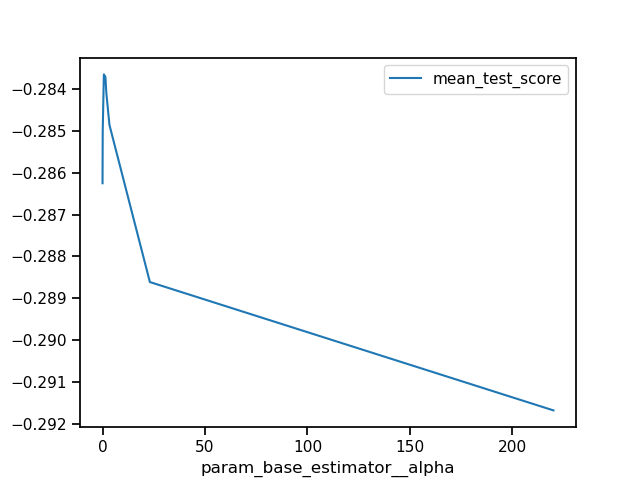

time: 178 ms


In [14]:
print(model.best_score_)
print(model.best_params_)
df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
results_df = pd.concat([results_df, df], axis="rows")

In [15]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={"base_estimator__alpha": loguniform(1e-2, 1e2)},
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 2,
    error_score="raise",
).fit(data, labels.valence)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
time: 34.9 s


-0.28357865561165657
{'base_estimator__alpha': 0.7440161610160553}


<AxesSubplot:xlabel='param_base_estimator__alpha'>

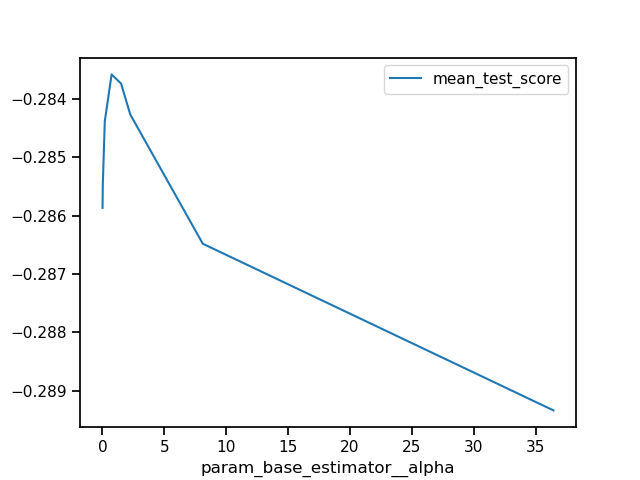

time: 215 ms


In [16]:
print(model.best_score_)
print(model.best_params_)
df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
results_df = pd.concat([results_df, df], axis="rows")

In [17]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={"base_estimator__alpha": loguniform(1e-2, 10)},
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 2,
    error_score="raise",
).fit(data, labels.valence)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
time: 34.4 s


-0.2836740160879817
{'base_estimator__alpha': 0.5809740926532296}


,param_base_estimator__alpha,mean_test_score
2,0.580974,-0.283674
7,1.519932,-0.283745
9,0.431326,-0.283875
8,0.37425,-0.283904
5,0.25333,-0.284172
0,0.092462,-0.284950
1,4.691021,-0.285458
4,0.026548,-0.285570
3,0.023977,-0.285634
6,0.011648,-0.285888


<AxesSubplot:xlabel='param_base_estimator__alpha'>

<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
2,-0.543049,-0.283674
7,0.418666,-0.283745
9,-0.840891,-0.283875
8,-0.982831,-0.283904
5,-1.373062,-0.284172
0,-2.380954,-0.284950
1,1.545650,-0.285458
4,-3.628820,-0.285570
3,-3.730675,-0.285634
6,-4.452580,-0.285888


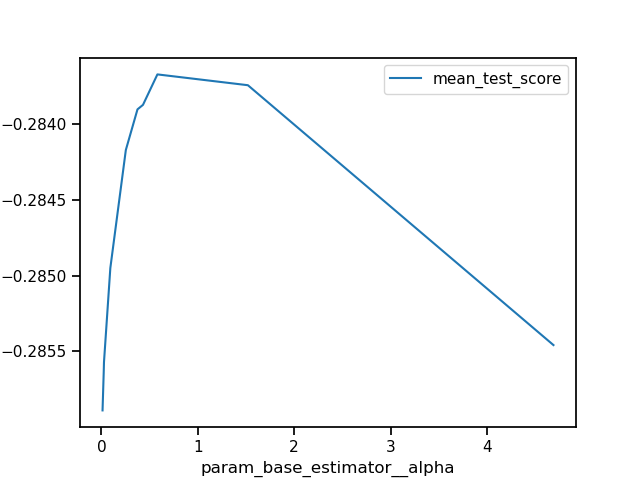

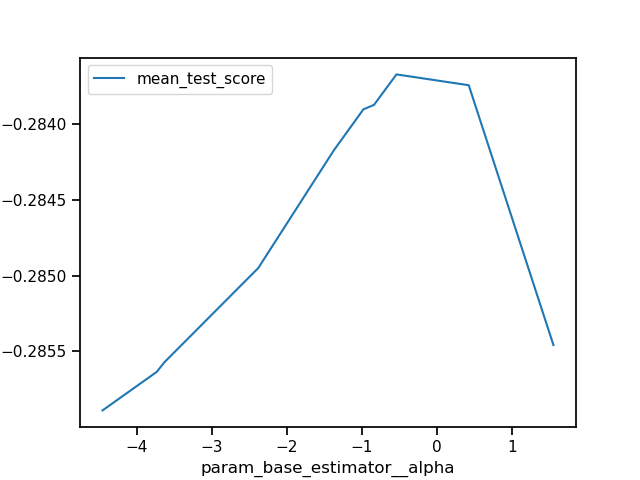

time: 301 ms


In [18]:
print(model.best_score_)
print(model.best_params_)
df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
df.sort_values(by="mean_test_score", ascending=False)
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
results_df = pd.concat([results_df, df], axis="rows")
df_ = deepcopy(df)
df_.param_base_estimator__alpha = df_.param_base_estimator__alpha.astype(
    np.float64
).swifter.apply(np.log)
df_.plot(x="param_base_estimator__alpha", y="mean_test_score")
df_.sort_values(by="mean_test_score", ascending=False)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
-0.2835926262940773
{'base_estimator__alpha': 0.7770025637764224}


,param_base_estimator__alpha,mean_test_score
1,0.777003,-0.283593
7,0.533672,-0.283735
2,0.387304,-0.283902
9,0.3507,-0.283942
8,0.334493,-0.283985
5,0.293694,-0.284052
0,0.209888,-0.284307
4,0.138465,-0.284692
3,0.133843,-0.284720
6,0.105218,-0.284880


<AxesSubplot:xlabel='param_base_estimator__alpha'>

<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
1,-0.252312,-0.283593
7,-0.627973,-0.283735
2,-0.948545,-0.283902
9,-1.047825,-0.283942
8,-1.095139,-0.283985
5,-1.225216,-0.284052
0,-1.561180,-0.284307
4,-1.977135,-0.284692
3,-2.011087,-0.284720
6,-2.251722,-0.284880


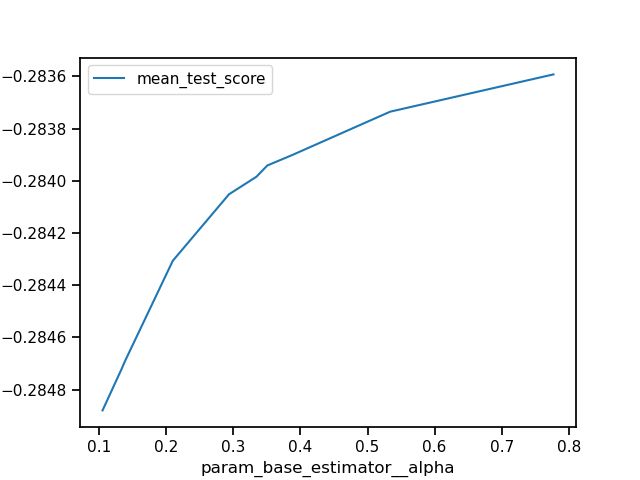

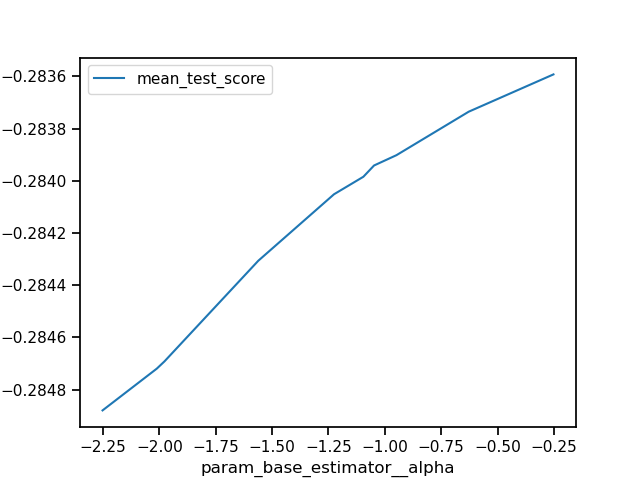

time: 34.9 s


In [19]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={"base_estimator__alpha": loguniform(0.1, 1)},
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 2,
    error_score="raise",
).fit(data, labels.valence)
print(model.best_score_)
print(model.best_params_)
df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
df.sort_values(by="mean_test_score", ascending=False)
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
results_df = pd.concat([results_df, df], axis="rows")
df_ = deepcopy(df)
df_.param_base_estimator__alpha = df_.param_base_estimator__alpha.astype(
    np.float64
).swifter.apply(np.log)
df_.plot(x="param_base_estimator__alpha", y="mean_test_score")
df_.sort_values(by="mean_test_score", ascending=False)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
-0.2835681381973336
{'base_estimator__alpha': 0.8360128183393862}


,param_base_estimator__alpha,mean_test_score
5,0.836013,-0.283568
2,0.953987,-0.283573
9,0.909851,-0.283585
8,0.889542,-0.283604
0,0.712193,-0.283612
7,1.11165,-0.283668
3,0.574608,-0.283674
4,0.583992,-0.283683
1,1.329871,-0.283690
6,0.512282,-0.283760


<AxesSubplot:xlabel='param_base_estimator__alpha'>

<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
5,-0.179111,-0.283568
2,-0.047106,-0.283573
9,-0.094475,-0.283585
8,-0.117049,-0.283604
0,-0.339407,-0.283612
7,0.105846,-0.283668
3,-0.554067,-0.283674
4,-0.537868,-0.283683
1,0.285082,-0.283690
6,-0.668879,-0.283760


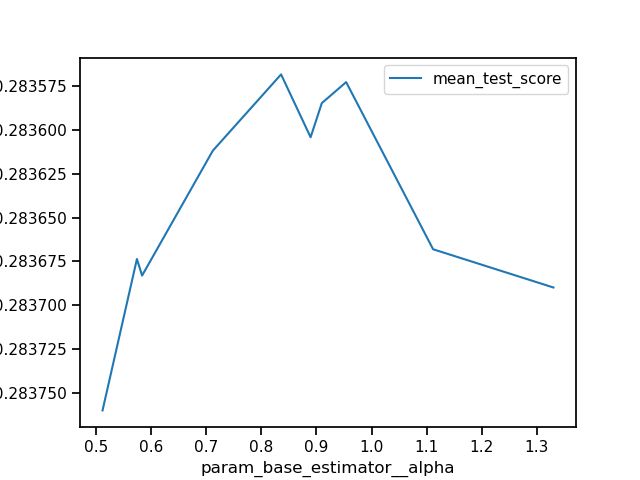

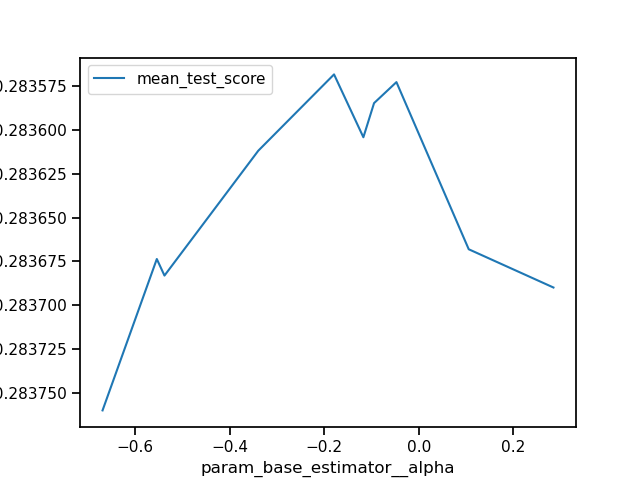

time: 34.9 s


In [20]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={"base_estimator__alpha": loguniform(0.5, 1.5)},
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 2,
    error_score="raise",
).fit(data, labels.valence)
print(model.best_score_)
print(model.best_params_)
df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
df.sort_values(by="mean_test_score", ascending=False)
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
results_df = pd.concat([results_df, df], axis="rows")
df_ = deepcopy(df)
df_.param_base_estimator__alpha = df_.param_base_estimator__alpha.astype(
    np.float64
).swifter.apply(np.log)
df_.plot(x="param_base_estimator__alpha", y="mean_test_score")
df_.sort_values(by="mean_test_score", ascending=False)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
-0.28356509527924756
{'base_estimator__alpha': 0.9758449935636512}


,param_base_estimator__alpha,mean_test_score
1,0.975845,-0.283565
7,0.940958,-0.283573
4,0.825634,-0.283574
3,0.822922,-0.283576
6,0.803953,-0.283581
2,0.912175,-0.283588
0,0.859595,-0.283590
9,0.903441,-0.283593
8,0.899308,-0.283598
5,0.888043,-0.283603


<AxesSubplot:xlabel='param_base_estimator__alpha'>

<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
1,-0.024452,-0.283565
7,-0.060857,-0.283573
4,-0.191604,-0.283574
3,-0.194894,-0.283576
6,-0.218214,-0.283581
2,-0.091923,-0.283588
0,-0.151294,-0.283590
9,-0.101545,-0.283593
8,-0.106130,-0.283598
5,-0.118736,-0.283603


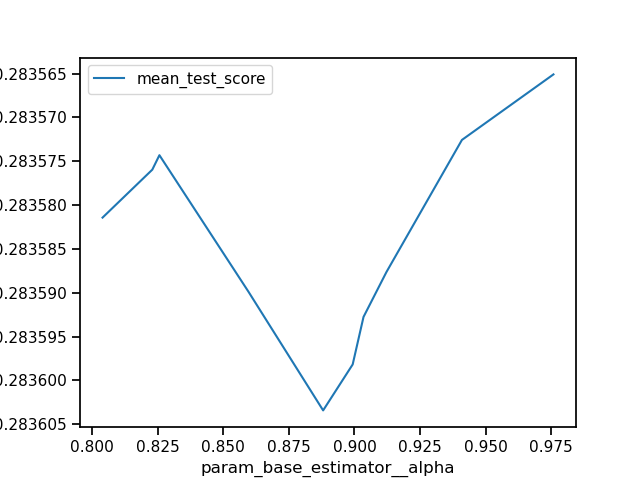

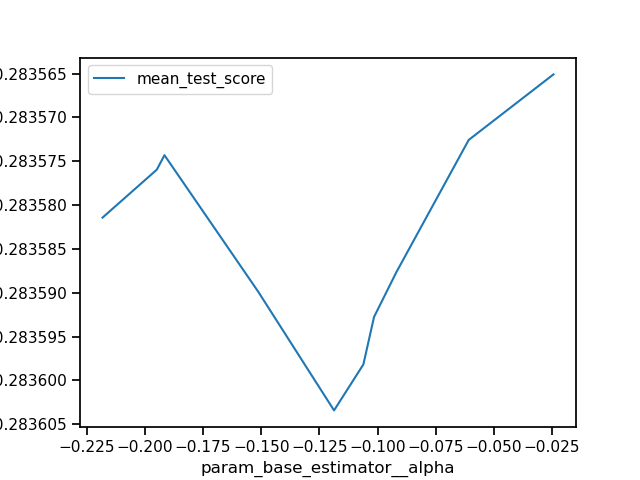

time: 36.5 s


In [21]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={"base_estimator__alpha": loguniform(0.8, 1.0)},
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 2,
    error_score="raise",
).fit(data, labels.valence)
print(model.best_score_)
print(model.best_params_)
df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
df.sort_values(by="mean_test_score", ascending=False)
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
results_df = pd.concat([results_df, df], axis="rows")
df_ = deepcopy(df)
df_.param_base_estimator__alpha = df_.param_base_estimator__alpha.astype(
    np.float64
).swifter.apply(np.log)
df_.plot(x="param_base_estimator__alpha", y="mean_test_score")
df_.sort_values(by="mean_test_score", ascending=False)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
-0.2835634308223209
{'base_estimator__alpha': 0.9600720946319352}


,param_base_estimator__alpha,mean_test_score
0,0.960072,-0.283563
8,0.999869,-0.283574
5,0.988598,-0.283579
9,1.004,-0.283584
4,0.925892,-0.283586
2,1.012725,-0.283587
3,0.923157,-0.283589
6,0.903998,-0.283591
7,1.041417,-0.283616
1,1.076076,-0.283639


<AxesSubplot:xlabel='param_base_estimator__alpha'>

<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
0,-0.040747,-0.283563
8,-0.000131,-0.283574
5,-0.011468,-0.283579
9,0.003992,-0.283584
4,-0.076997,-0.283586
2,0.012644,-0.283587
3,-0.079956,-0.283589
6,-0.100928,-0.283591
7,0.040582,-0.283616
1,0.073321,-0.283639


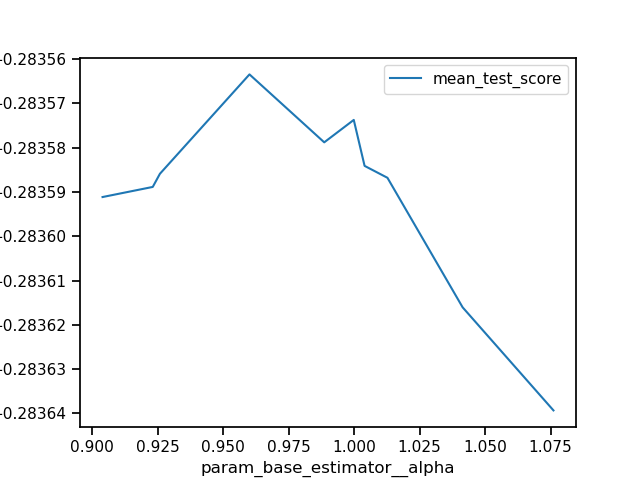

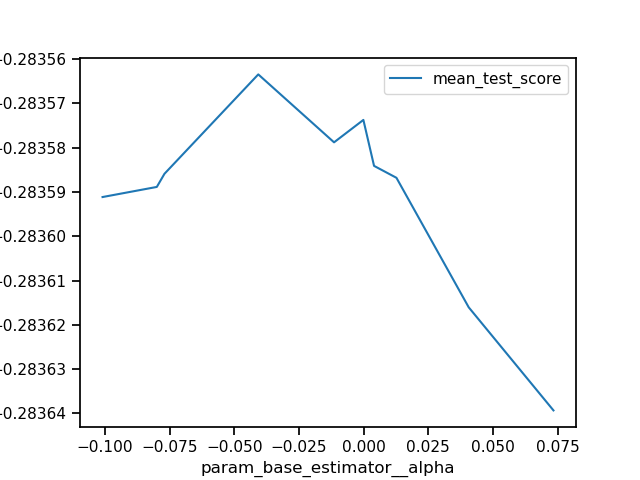

time: 36 s


In [22]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={"base_estimator__alpha": loguniform(0.9, 1.1)},
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 2,
    error_score="raise",
).fit(data, labels.valence)
print(model.best_score_)
print(model.best_params_)
df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
df.sort_values(by="mean_test_score", ascending=False)
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
results_df = pd.concat([results_df, df], axis="rows")
df_ = deepcopy(df)
df_.param_base_estimator__alpha = df_.param_base_estimator__alpha.astype(
    np.float64
).swifter.apply(np.log)
df_.plot(x="param_base_estimator__alpha", y="mean_test_score")
df_.sort_values(by="mean_test_score", ascending=False)

In [23]:
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{DATA_OUT_FOLDER}/ridge_results.csv")

time: 7.99 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
0,0.960072,-0.283563
8,0.999869,-0.283574
5,0.988598,-0.283579
9,1.004,-0.283584
4,0.925892,-0.283586
2,1.012725,-0.283587
3,0.923157,-0.283589
6,0.903998,-0.283591
7,1.041417,-0.283616
1,1.076076,-0.283639


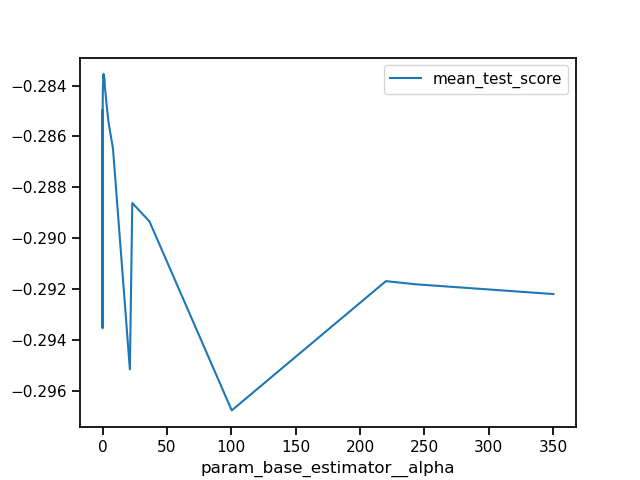

time: 189 ms


In [24]:
results_df = results_df.sort_values(by="param_base_estimator__alpha", ascending=True)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
df.sort_values(by="mean_test_score", ascending=False)

In [25]:
max_score = results_df.mean_test_score.max()
results_df.loc[results_df.mean_test_score == max_score]
results_df.loc[results_df.mean_test_score == max_score].param_base_estimator__alpha

,param_base_estimator__alpha,mean_test_score
0,0.960072,-0.283563


0    0.960072
Name: param_base_estimator__alpha, dtype: object

time: 14 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

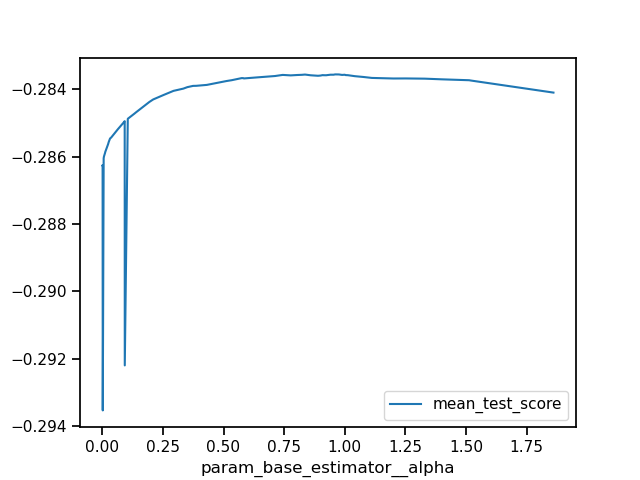

time: 186 ms


In [27]:
results_df.loc[results_df.param_base_estimator__alpha < 2].plot(
    x="param_base_estimator__alpha", y="mean_test_score"
)

# Discussion

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [ ]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

[^top](#Contents)